In [1]:
import pandas as pd
import numpy as np

from google.api_core import retry
import vertexai
from vertexai.language_models import TextEmbeddingModel, TextEmbeddingInput
import vertexai_config

vertexai.init(project=vertexai_config.project_id, location='us-central1')

from tqdm.auto import tqdm
tqdm.pandas()

import seaborn as sns
from sklearn.manifold import TSNE

import os

In [2]:
df = pd.read_csv('data/balanced_corpus.csv')
df

,Unnamed: 0,text,place,uri,collector,area,lat,lon
0,105697,Γέλια σαν κομπολόγια,"Ήπειρος, Ζαγόρι, Βίτσα",http://hdl.handle.net/20.500.11853/168435,"Σάρρος, Δημήτριος Μ.",Ήπειρος,37.998253,23.737867
1,8413,Καρδίαν καθαράν θέλ' ο Θεός,Ήπειρος,http://hdl.handle.net/20.500.11853/167032,"Γόνιος, Α.",Ήπειρος,37.998253,23.737867
2,7684,Ου Θεός κι ου γείτονας,Ήπειρος,http://hdl.handle.net/20.500.11853/168991,"Γαλδέμης, Αναστάσιος Δ.",Ήπειρος,37.998253,23.737867
3,18546,Θέλει να κρυφθή πίσω από το δάχτυλό του,Ήπειρος,http://hdl.handle.net/20.500.11853/273352,"Ζηκίδης, Γεώργιος Δ.",Ήπειρος,37.998253,23.737867
4,94001,Όλοι κλαίν' τα χάλια τ'ς κι ο μυλωνάς τη δέσι,Ήπειρος,http://hdl.handle.net/20.500.11853/204755,"Παπαγεωργίου, Ιωάννης",Ήπειρος,37.998253,23.737867
...,...,...,...,...,...,...,...,...
11495,101735,Παστρζικό τσανα τσ' έναι!,Σκύρος,http://hdl.handle.net/20.500.11853/247609,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477
11496,101233,"Κάλλιο γεναίκα κάμισσα, πέρζι πολυπροικούσα",Σκύρος,http://hdl.handle.net/20.500.11853/195541,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477
11497,101612,Όγοιος κάθεται στη στερζά τσαί θάλασσα γερεύει...,Σκύρος,http://hdl.handle.net/20.500.11853/195683,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477
11498,101762,Πήε στ' δαιμόνου τ' μάννα,Σκύρος,http://hdl.handle.net/20.500.11853/195537,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477


In [3]:
df['area'].value_counts()

area
Ήπειρος            500
Κεφαλληνία         500
Ρόδος              500
Πόντος             500
Νάξος              500
Μικρά Ασία         500
Μακεδονία          500
Λακωνία            500
Λέσβος             500
Κύπρος             500
Κρήτη              500
Κάρπαθος           500
Αιτωλία            500
Ιωάννινα           500
Θράκη              500
Θεσπρωτία          500
Εύβοια             500
Επτάνησος          500
Αχαΐα              500
Αρκαδία            500
Ανατολική Θράκη    500
Αμοργός            500
Σκύρος             500
Name: count, dtype: int64

In [4]:
def make_embed_text_fn(model):

  @retry.Retry(timeout=300.0)
  def embed_fn(text: str) -> list[float]:
    embedding = model.get_embeddings(
      [TextEmbeddingInput(text, "CLASSIFICATION")])
    return embedding[0].values

  return embed_fn

In [5]:
def create_embeddings(model, df):
  embeddings = df['text'].progress_apply(make_embed_text_fn(model)).to_list()
  df_emb = pd.DataFrame(embeddings)
  return df_emb

In [6]:
if not os.path.exists("gemini_embeddings.csv"):
    model = TextEmbeddingModel.from_pretrained(
        'text-multilingual-embedding-002')
    df_emb = create_embeddings(model, df)
    df_emb.to_csv('gemini_embeddings.csv', index=False)
    df_emb.to_pickle('gemini_embeddings.pkl')
else:
    df_emb = pd.read_csv("gemini_embeddings.csv")
df_emb

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.027455,-0.053877,0.030115,0.005643,-0.019186,0.080695,-0.038582,0.029594,-0.027510,-0.034477,...,0.020085,-0.034311,0.064325,-0.072853,0.006902,0.050923,-0.004415,-0.016331,0.001543,0.037961
1,0.000419,-0.032357,-0.000648,-0.026566,0.019869,0.061407,-0.027564,0.033231,0.000554,-0.056204,...,-0.007463,-0.032477,0.081760,-0.061901,-0.010328,0.032229,-0.041350,-0.027330,-0.036312,0.062047
2,-0.010723,-0.032000,0.009230,-0.002133,0.013183,0.055309,-0.013879,0.045692,0.031709,-0.055779,...,-0.001608,-0.031821,0.047081,-0.067666,-0.010880,0.028363,-0.008433,-0.002314,-0.048925,0.063307
3,-0.014442,-0.054716,0.025958,-0.030557,-0.010389,0.057768,0.012224,0.013234,0.015435,-0.062351,...,0.007223,0.008916,0.063947,-0.082083,-0.006257,0.019021,-0.010847,0.029537,-0.051006,0.037482
4,-0.027412,-0.051288,0.026337,-0.003127,0.011819,0.077733,-0.034342,0.029859,0.006355,-0.077810,...,0.017753,-0.023849,0.052784,-0.088730,0.009638,0.020241,-0.005727,-0.011415,-0.036332,0.043385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,-0.030706,-0.018605,0.004515,-0.003101,0.017148,0.063173,-0.038061,0.065474,0.026756,-0.073357,...,0.024660,-0.039649,0.049566,-0.087292,0.012302,0.061522,-0.020315,-0.016402,-0.014745,0.060315
11496,-0.007343,-0.055495,0.036710,0.002464,0.019892,0.062775,-0.010482,0.038977,0.016519,-0.057585,...,0.003168,0.001254,0.038874,-0.067781,-0.012099,0.049767,-0.036994,0.013672,-0.012259,0.047384
11497,-0.008590,-0.040834,0.008327,-0.002388,0.009710,0.069349,-0.016042,0.037970,0.005784,-0.049311,...,-0.009837,-0.033955,0.071447,-0.067473,0.004163,0.021428,-0.030723,-0.000316,-0.005357,0.042210
11498,-0.024564,-0.037762,0.003206,-0.001025,0.005065,0.076452,-0.002703,0.078233,0.001559,-0.041770,...,0.002314,-0.045572,0.051578,-0.041436,-0.012345,0.043323,-0.005370,-0.016984,-0.060490,0.045995


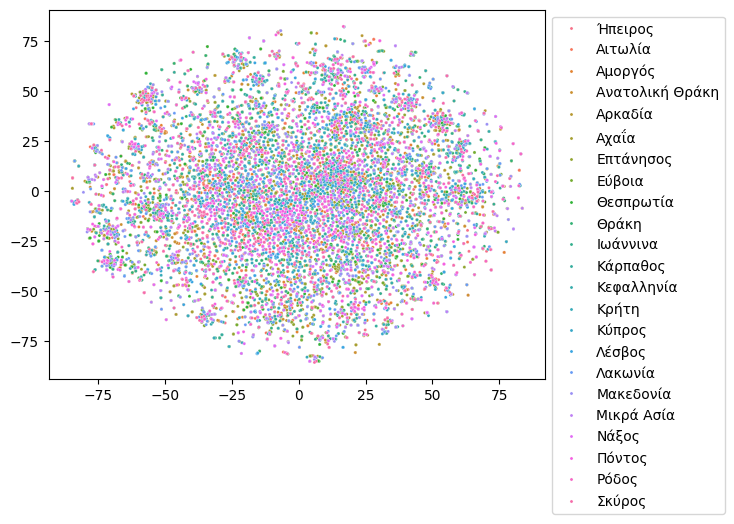

In [7]:
tsne = TSNE(n_components=2, random_state=0).fit_transform(df_emb)
ax = sns.scatterplot(x=tsne[:, 0], 
                     y=tsne[:, 1], 
                     s=5,
                     hue=np.array(df['area'].to_list()))
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))